In [1]:
import pandas as pd
import numpy as np
import orbit

from orbit.utils.dataset import load_iclaims
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.models import ETS

In [2]:
orbit.__version__

'1.0.16dev'

In [3]:
%load_ext autoreload
%autoreload 2

## Data

In [4]:
raw_df = load_iclaims()

raw_df.dtypes

week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

In [5]:
df = raw_df.copy()

In [6]:
df.head()

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


In [7]:
test_size=52

train_df=df[:-test_size]
test_df=df[-test_size:]

In [13]:
ets = ETS(response_col='claims',
          date_col='week',
          seasonality=52,
          seed=2020,
          estimator='stan-map'
         )

In [14]:
ets.fit(train_df)

Initial log joint probability = 599.107
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19        882.91     0.0293331       25.0516      0.2291      0.2291       28   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       887.252      0.134097       9.64316           1           1       53   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       887.536    0.00117159      0.128672           1           1       75   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       887.536   0.000247269     0.0210903           1           1       82   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [15]:
predicted_df = ets.predict(df=df, decompose=True)
predicted_df

,week,prediction,trend,seasonality
0,2010-01-03,13.386595,13.051014,0.335581
1,2010-01-10,13.617983,13.052341,0.565642
2,2010-01-17,13.382794,13.055735,0.327059
3,2010-01-24,13.146663,13.053795,0.092868
4,2010-01-31,13.172100,13.059043,0.113056
...,...,...,...,...
438,2018-05-27,12.329127,12.427405,-0.098278
439,2018-06-03,12.269740,12.427405,-0.157665
440,2018-06-10,12.368060,12.427405,-0.059345
441,2018-06-17,12.338719,12.427405,-0.088687


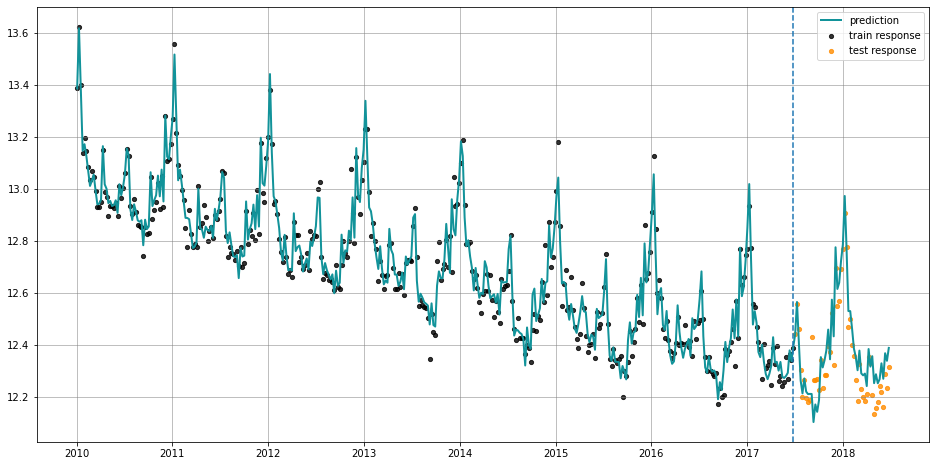

In [16]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col='week',
                        actual_col='claims',
                        test_actual_df=test_df)

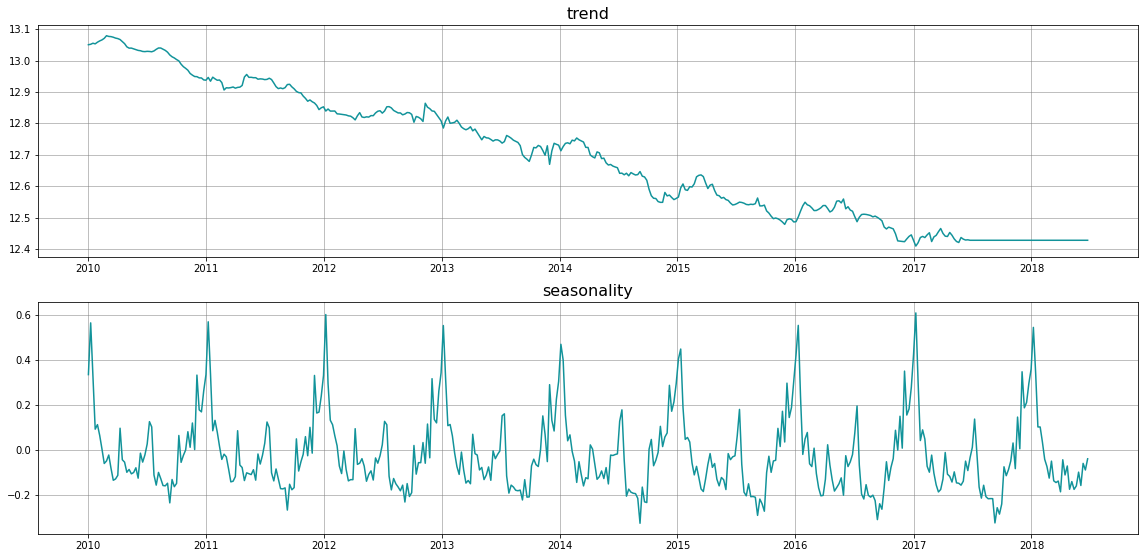

In [17]:
_ = plot_predicted_components(predicted_df=predicted_df, date_col='week')

In [18]:
from custom_inherit._doc_parse_tools.numpy_parse_tools import parse_numpy_doc

In [19]:
ETS.__doc__

"\n    Args\n    ----------\n    response_col : str\n        Name of response variable column, default 'y'\n    date_col : str\n        Name of date variable column, default 'ds'\n    seasonality : int\n        Length of seasonality\n    seasonality_sm_input : float\n        float value between [0, 1], applicable only if `seasonality` > 1. A larger value puts\n        more weight on the current seasonality.\n        If None, the model will estimate this value.\n    level_sm_input : float\n        float value between [0.0001, 1]. A larger value puts more weight on the current level.\n        If None, the model will estimate this value.\n    estimator: string\n    **kwargs:\n        additional arguments passed into orbit.estimators.stan_estimator or orbit.estimators.pyro_estimator\n    "

In [20]:
 parse_numpy_doc(prnt_doc)

NameError: name 'prnt_doc' is not defined